In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.utils import plot_model
from keras import backend as K
import pydot

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = np.reshape(X_train, [-1, 28, 28, 1])
X_test = np.reshape(X_test, [-1, 28, 28, 1])
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [4]:
inputs = Input(shape = (28, 28, 1), name = 'encoder_input')

In [5]:
x = inputs

In [6]:
x = Conv2D(32, (3,3), activation = 'relu', strides = 2, padding = 'same')(x)
x = Conv2D(64, (3,3), activation = 'relu', strides = 2, padding = 'same')(x)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
shape = K.int_shape(x)

In [8]:
print(shape)

(None, 7, 7, 64)


In [9]:
x = Flatten()(x)
latent = Dense(16, name = 'latent_vector')(x)

In [10]:
encoder = Model(inputs, latent, name = 'encoder')

In [11]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


In [12]:
plot_model(encoder, to_file = 'encoder.png', show_shapes = True)

In [13]:
latent_inputs = Input(shape = (16,), name = 'decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [14]:
x = Conv2DTranspose(64, (3,3), activation = 'relu', strides = 2, padding = 'same')(x)
x = Conv2DTranspose(32, (3,3), activation = 'relu', strides = 2, padding = 'same')(x)

In [15]:
outputs = Conv2DTranspose(1, (3,3), activation = 'sigmoid', padding = 'same', name = 'decode_output')(x)

In [16]:
decoder = Model(latent_inputs, outputs, name = 'decoder')

In [17]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decode_output (Conv2DTranspo (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_________________________________________________________________


In [18]:
plot_model(decoder, to_file = 'decoder.png', show_shapes = True)

In [19]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name = 'autoencoder')

In [20]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [21]:
plot_model(autoencoder, to_file = 'autoencoder.png', show_shapes = True)

In [22]:
autoencoder.compile(loss = 'mse', optimizer = 'Adam')

In [23]:
autoencoder.fit(X_train, X_train, validation_data=(X_test, X_test), epochs = 1, batch_size = 32)

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 80s 1ms/step - loss: 0.0218 - val_loss: 0.0105


In [24]:
encoder.save('encoder.h5')

In [25]:
decoder.save('decoder.h5')

In [ ]:
autoencoder.

In [27]:
x_decoded = autoencoder.predict(X_test)

In [30]:
print(x_decoded.shape)

(10000, 28, 28, 1)


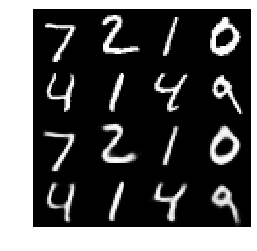

In [33]:
imgs = np.concatenate([X_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, 28, 28))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.imshow(imgs, interpolation = 'none', cmap = 'gray')
plt.savefig('input_and_decoded.png')
plt.show()